In [ ]:
# 必要なライブラリをインストール
!pip install -U statsmodels
!pip install japanize_matplotlib

In [2]:
# プログラム1.1
import math

import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6

In [3]:
# matplotlibで日本語を表示させる
import japanize_matplotlib
# Colabでファイルを読み込むために、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


         四半期  GDPギャップ
0    1980.01     -0.6
1    1980.02     -2.2
2    1980.03     -1.1
3    1980.04      0.0
4    1981.01     -0.2
..       ...      ...
160  2020.01     -2.5
161  2020.02    -10.5
162  2020.03     -5.8
163  2020.04     -3.3
164  2021.01     -4.7

[165 rows x 2 columns]


Text(0, 0.5, '％')

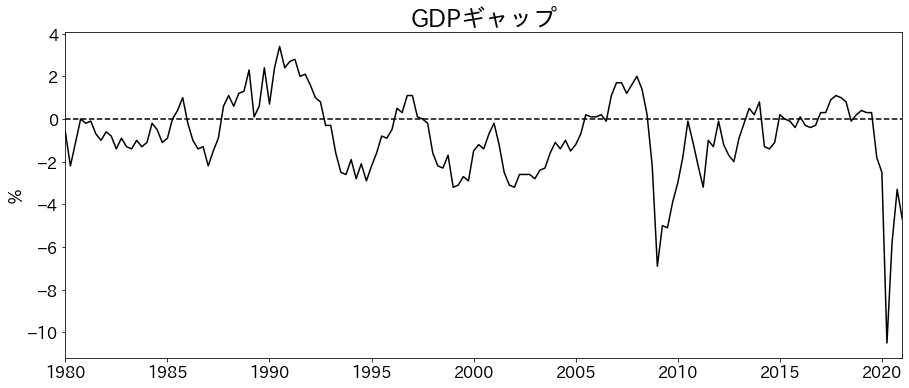

In [4]:
# プログラム1.2
# データの読み込み
gap = pd.read_excel("/content/drive/My Drive/data_1.xlsx", sheet_name="GDPギャップ(内閣府)", header=[0])
dlen = len(gap)
caogap = gap.iloc[0:dlen, 1]
dti = pd.date_range("1980-01-01", periods=dlen, freq="QS")
# データの出力
print(gap)

# グラフの描画
plt.title("GDPギャップ", fontsize=24)
plt.plot(dti, caogap, color="black")
plt.hlines([0], dti[0], dti[-1], color="black", linestyles="dashed")
plt.tick_params(labelsize=16)
plt.xlim(dti[0], dti[-1])
plt.ylabel("％", fontsize=16)

In [5]:
# プログラム1.3
# AR(1)モデルの推定
model = sm.tsa.AutoReg(caogap, lags=1)
result = model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                GDPギャップ   No. Observations:                  165
Model:                     AutoReg(1)   Log Likelihood                -250.353
Method:               Conditional MLE   S.D. of innovations              1.114
Date:                Sun, 10 Jul 2022   AIC                            506.705
Time:                        03:45:08   BIC                            516.005
Sample:                             1   HQIC                           510.481
                                  165                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1708      0.094     -1.811      0.070      -0.356       0.014
GDPギャップ.L1     0.8094      0.048     16.970      0.000       0.716       0.903
                                    Roots           

Text(0.5, 0, 'ラグ次数')

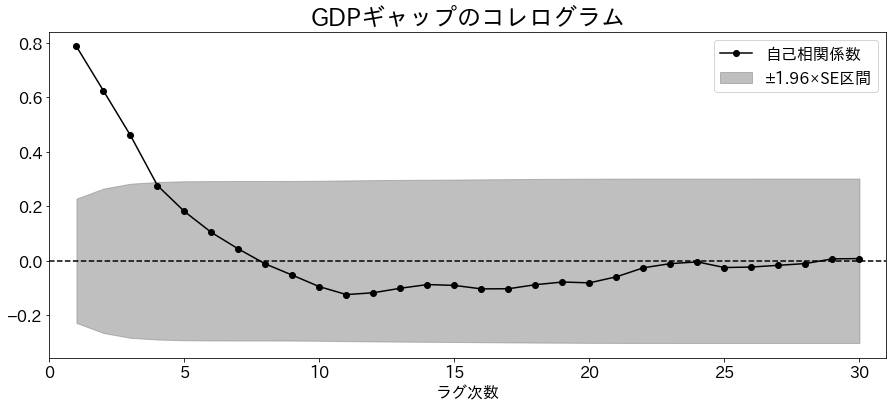

In [6]:
# プログラム1.4
# コレログラムの計算
H = 30  # ラグ次数（30四半期）
CONFIDENCE_LEVEL = 0.95  # 有意水準
autoc, se = np.zeros(H), np.zeros(H)
lbound, ubound = sp.stats.norm.interval(alpha=CONFIDENCE_LEVEL, loc=0, scale=1)
for i in range(1, H + 1):
    x, y = pd.DataFrame(caogap[i:].to_numpy()), pd.DataFrame(caogap[:-i].to_numpy())
    model = LinearRegression()
    result = model.fit(x, y)
    autoc[i - 1] = result.coef_
    se[i - 1] = (
        1 / len(caogap) * (1 + 2 * sum([autoc[x] ** 2 for x in range(i)]))
    ) ** (1 / 2)

# グラフの描画
hlabel = pd.DataFrame(range(1, H + 1))
plt.title("GDPギャップのコレログラム", fontsize=24)
plt.plot(np.ravel(hlabel), autoc, color="black", label="自己相関係数", marker="o")
plt.hlines([0], 0, H + 1, color="black", linestyles="dashed")
plt.fill_between(
    np.ravel(hlabel), ubound * se, lbound * se, color="grey", alpha=0.5, label="±1.96×SE区間"
)
plt.legend(loc="upper right", fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(0, H + 1)
plt.xlabel("ラグ次数", fontsize=16)

In [7]:
# プログラム1.5
# ボックス・ピアースのQ検定、リュン・ボックスの修正Q検定
LAG = 8  # ラグ次数（8四半期）
rho_lag, q_bp, q_lb, crit = np.zeros(LAG), np.zeros(LAG), np.zeros(LAG), np.zeros(LAG)
for i in range(1, LAG + 1):
    data_x, data_y = pd.DataFrame(caogap[: dlen - i]), pd.DataFrame(caogap[i:])
    model_lag = LinearRegression(fit_intercept=True)
    model_lag.fit(data_x, data_y)
    rho_lag[i - 1] = model_lag.coef_
    # ボックス・ピアースのQ検定統計量
    q_bp[i - 1] = dlen * sum(rho_lag**2)
    # リュン・ボックスの修正Q検定統計量
    q_lb[i - 1] = dlen * (dlen + 2) * sum(rho_lag**2 / (dlen - i))
    # カイ2乗分布の臨界値
    crit[i - 1] = sp.stats.chi2.ppf(q=0.95, df=i)
# 結果表の作成
df_table = pd.DataFrame(
    [rho_lag, q_bp, q_lb, crit],
    columns=[f"lag={i+1}" for i in range(LAG)],
    index=["相関係数", "Q_BP", "Q_LB", "臨界値"],
)
print(df_table)

           lag=1       lag=2       lag=3       lag=4       lag=5       lag=6  \
相関係数    0.809377    0.647305    0.501310    0.369914    0.244137    0.140524   
Q_BP  108.090157  177.225805  218.692172  241.270209  251.104717  254.362991   
Q_LB  110.067416  181.574905  225.441930  250.261645  262.090549  267.161129   
臨界値     3.841459    5.991465    7.814728    9.487729   11.070498   12.591587   

           lag=7       lag=8  
相関係数    0.058660   -0.015943  
Q_BP  254.930746  254.972688  
Q_LB  269.452118  271.212986  
臨界値    14.067140   15.507313  


Text(0, 0.5, '％')

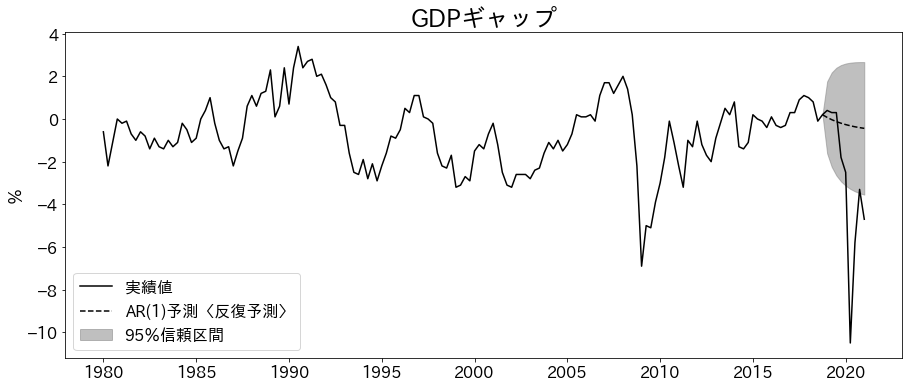

In [8]:
# プログラム1.6
# AR(1)モデルによる予測と予測誤差（反復予測）
L = 1  # ARモデルのラグ次数（1四半期）
MAX_H = 9  # 最大予測期間（9四半期）
CONFIDENCE_LEVEL = 0.95  # 区間予測の信頼係数

# 1980年～2018年までのデータを用いてARモデルを推定
dti = pd.date_range("1980-01-01", periods=dlen, freq="QS")
ssize = sum(dti.year < 2019)
lbound, ubound = sp.stats.norm.interval(alpha=CONFIDENCE_LEVEL, loc=0, scale=1)
predict_result, conf_result = np.zeros(MAX_H), np.zeros(MAX_H)
for h in range(MAX_H):
    for l in range(1, L + 1):
        train_x, train_y = pd.DataFrame(), pd.DataFrame(caogap[L : ssize])
        test_x = pd.DataFrame()
        for ll in range(1, l + 1):
            train_x_lagged = pd.DataFrame(
                caogap[L - ll : L - ll + len(train_y)].to_numpy()
            )
            train_x = pd.concat([train_x, train_x_lagged], axis=1)
        for ll in range(1, l + 1):
            test_x_lagged = pd.DataFrame(
                caogap[
                    ssize + l - ll - (l - 1) - 1 : ssize + l - ll - (l - 1)
                ].to_numpy()
            )
            test_x = pd.concat([test_x, test_x_lagged], axis=1)
    # ARモデルの推定
    model = LinearRegression()
    model.fit(train_x, train_y)
    # 予測値の計算
    for _ in range(h + 1):
        y_hat = model.predict(train_x)
        forecast = pd.DataFrame(
            np.sum((test_x * model.coef_).to_numpy()) + model.intercept_
        )
        test_x = pd.concat(
            [forecast, pd.DataFrame((test_x.T[:-1]).T.to_numpy())], axis=1
        )
    predict_result[h] = forecast.to_numpy()
    # 予測の信頼区間の計算
    se = np.std(train_y.to_numpy() - y_hat)
    bmat = np.zeros((L, L))
    bmat[0, :] = model.coef_
    for i in range(1, L):
        bmat[i, i - 1] = 1
    smat = np.zeros((L, L))
    smat[0, 0] = 1
    cvec = np.zeros((1, L))
    cvec[:, 0] = 1
    coef = sum(
        cvec
        @ np.linalg.matrix_power(bmat, x)
        @ smat
        @ np.linalg.matrix_power(bmat, x)
        @ cvec.T
        for x in range(h + 1)
    )
    conf_result[h] = coef ** (1 / 2) * se * ubound
ar_forecast = (
    pd.concat([caogap[0:ssize], pd.DataFrame(predict_result)], axis=0)
).to_numpy()
ar_bound = (
    pd.concat([pd.DataFrame(np.zeros(ssize)), pd.DataFrame(conf_result)], axis=0)
).to_numpy()
ar_ubound, ar_lbound = ar_forecast + ar_bound, ar_forecast - ar_bound

# グラフの描画
plt.title("GDPギャップ", fontsize=24)
plt.plot(dti, caogap, label="実績値", color="black")
plt.plot(
    dti[ssize - 1 : ssize + MAX_H],
    ar_forecast[ssize - 1 : ssize + MAX_H, :],
    label="AR(1)予測〈反復予測〉",
    color="black",
    linestyle="dashed",
)
plt.fill_between(
    np.ravel(dti[ssize - 1 : ssize + MAX_H]),
    np.ravel(ar_ubound[ssize - 1 : ssize + MAX_H, :]),
    np.ravel(ar_lbound[ssize - 1 : ssize + MAX_H, :]),
    color="grey",
    alpha=0.5,
    label="95％信頼区間",
)
plt.legend(loc="lower left", fontsize=16)
plt.tick_params(labelsize=16)
plt.ylabel("％", fontsize=16)

In [9]:
# プログラム1.7
# AR(1)モデルによる予測と予測誤差（直接予測）
L = 1  # ARモデルのラグ次数（1四半期）
MAX_H = 9  # 最大予測期間（9四半期）
CONFIDENCE_LEVEL = 0.95  # 区間予測の信頼係数

# 1980年～2018年までのデータを用いてARモデルを推定
dti = pd.date_range("1980-01-01", periods=dlen, freq="QS")
ssize = sum(dti.year < 2019)
lbound, ubound = sp.stats.norm.interval(alpha=CONFIDENCE_LEVEL, loc=0, scale=1)
predict_result, conf_result = np.zeros(MAX_H), np.zeros(MAX_H)
for h in range(MAX_H):
    for l in range(1, L + 1):
        train_x, train_y = pd.DataFrame(), pd.DataFrame(caogap[L + h : ssize])
        test_x = pd.DataFrame()
        for ll in range(1, l + 1):
            train_x_lagged = pd.DataFrame(
                caogap[L - ll : L - ll + len(train_y)].to_numpy()
            )
            train_x = pd.concat([train_x, train_x_lagged], axis=1)
        for ll in range(1, l + 1):
            test_x_lagged = pd.DataFrame(
                caogap[
                    ssize + l - ll - (l - 1) - h - 1 : ssize + l - ll - (l - 1) - h
                ].to_numpy()
            )
            test_x = pd.concat([test_x, test_x_lagged], axis=1)
    # ARモデルの推定
    model = LinearRegression()
    model.fit(train_x, train_y)
    # 予測値の計算
    predict_result[h] = model.predict(test_x)
    # 予測の信頼区間の計算
    se = np.std(train_y.to_numpy() - model.predict(train_x))
    conf_result[h] = se * ubound
ar_forecast = pd.concat([caogap[0:ssize], pd.DataFrame(predict_result)], axis=0).to_numpy()
ar_bound = pd.concat(
    [pd.DataFrame(np.zeros(ssize)), pd.DataFrame(conf_result)], axis=0
).to_numpy()
ar_ubound, ar_lbound = ar_forecast + ar_bound, ar_forecast - ar_bound

Text(0, 0.5, '％')

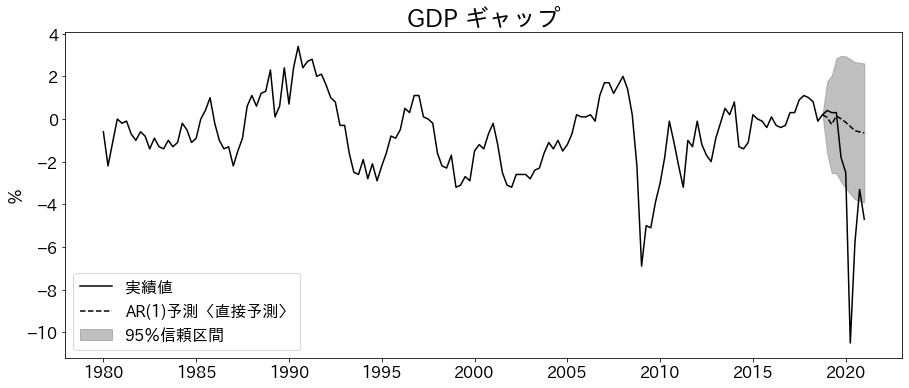

In [10]:
#####
# グラフの描画
plt.title("GDP ギャップ", fontsize=24)
plt.plot(dti, caogap, label="実績値", color="black")
plt.plot(
    dti[ssize - 1 : ssize + MAX_H],
    ar_forecast[ssize - 1 : ssize + MAX_H, :],
    label="AR(1)予測〈直接予測〉",
    color="black",
    linestyle="dashed",
)
plt.fill_between(
    np.ravel(dti[ssize - 1 : ssize + MAX_H]),
    np.ravel(ar_ubound[ssize - 1 : ssize + MAX_H, :]),
    np.ravel(ar_lbound[ssize - 1 : ssize + MAX_H, :]),
    color="grey",
    alpha=0.5,
    label="95％信頼区間",
)
plt.legend(loc="lower left", fontsize=16)
plt.tick_params(labelsize=16)
plt.ylabel("％", fontsize=16)

In [11]:
# プログラム1.8
# GDPギャップのARモデルのラグ次数の選択
def get_aic_bic(caogap, y, y_hat, param1, param2):
    sse = ((y - y_hat) ** 2).sum(axis=0)
    aic = math.log(sse / (len(caogap) - param1)) + (l + 1) * 2 / (len(caogap) - param2)
    bic = math.log(sse / (len(caogap) - param1)) + (l + 1) * math.log(
        (len(caogap) - param2)
    ) / (len(caogap) - param2)
    return aic, bic


MAX_L = 4  # ARモデルの最大ラグ次数（4四半期）
aic_result, bic_result = np.zeros([MAX_L + 1, 3]), np.zeros([MAX_L + 1, 3])
# AR(0)モデルの場合
l = 0
# AIC・BICの計算方法1:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合
y = pd.DataFrame(caogap[MAX_L:])
aic_result[l, 0], bic_result[l, 0] = get_aic_bic(caogap, y, np.mean(y.to_numpy()), MAX_L, MAX_L)
# AIC・BICの計算方法2:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合（標本分散の自由度を調整）
y = pd.DataFrame(caogap[MAX_L:])
aic_result[l, 1], bic_result[l, 1] = get_aic_bic(
    caogap, y, np.mean(y.to_numpy()), MAX_L + l + 1, MAX_L
)
# AIC・BICの計算方法3:それぞれのARモデルで利用できる観測値をすべて利用した場合
y = pd.DataFrame(caogap[l:])
aic_result[l, 2], bic_result[l, 2] = get_aic_bic(caogap, y, np.mean(y.to_numpy()), l, l)

# AR(p)モデル（p>0）の場合
for l in range(1, MAX_L + 1):
    # AIC・BICの計算方法1:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合
    x, y = pd.DataFrame(), pd.DataFrame(caogap[MAX_L:])
    for ll in range(1, l + 1):
        x_lagged = pd.DataFrame(caogap[MAX_L - ll : MAX_L - ll + len(y)].to_numpy())
        x = pd.concat([x, x_lagged], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    aic_result[l, 0], bic_result[l, 0] = get_aic_bic(caogap, y, model.predict(x), MAX_L, MAX_L)

    # AIC・BICの計算方法2:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合（誤差項の標本分散の自由度を調整）
    x, y = pd.DataFrame(), pd.DataFrame(caogap[MAX_L:])
    for ll in range(1, l + 1):
        x_lagged = pd.DataFrame(caogap[MAX_L - ll : MAX_L - ll + len(y)].to_numpy())
        x = pd.concat([x, x_lagged], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    aic_result[l, 1], bic_result[l, 1] = get_aic_bic(
        caogap, y, model.predict(x), MAX_L + l + 1, MAX_L
    )

    # AIC・BICの計算方法3:それぞれのARモデルで利用できる観測値をすべて利用した場合
    x, y = pd.DataFrame(), pd.DataFrame(caogap[l:])
    for ll in range(1, l + 1):
        x_lagged = pd.DataFrame(caogap[l - ll : l - ll + len(y)].to_numpy())
        x = pd.concat([x, x_lagged], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    aic_result[l, 2], bic_result[l, 2] = get_aic_bic(caogap, y, model.predict(x), l, l)

# 結果表の作成
df_aic_result = pd.DataFrame(
    aic_result,
    columns=[f"方法{i+1}" for i in range(3)],
    index=[f"L={i}" for i in range(MAX_L + 1)],
)
df_bic_result = pd.DataFrame(
    bic_result,
    columns=[f"方法{i+1}" for i in range(3)],
    index=[f"L={i}" for i in range(MAX_L + 1)],
)
print("[AIC]\n", df_aic_result)
print("[BIC]\n", df_bic_result)
print("[best AIC lag length]\n", df_aic_result.idxmin())
print("[best BIC lag length]\n", df_bic_result.idxmin())

[AIC]
           方法1       方法2       方法3
L=0  1.254979  1.261210  1.235055
L=1  0.237441  0.249941  0.239595
L=2  0.249859  0.268668  0.246264
L=3  0.259668  0.284826  0.259438
L=4  0.263083  0.294631  0.263083
[BIC]
           方法1       方法2       方法3
L=0  1.274118  1.280349  1.253879
L=1  0.275719  0.288219  0.277398
L=2  0.307276  0.326086  0.303205
L=3  0.336224  0.361383  0.335675
L=4  0.358779  0.390327  0.358779
[best AIC lag length]
 方法1    L=1
方法2    L=1
方法3    L=1
dtype: object
[best BIC lag length]
 方法1    L=1
方法2    L=1
方法3    L=1
dtype: object


In [12]:
# プログラム1.9
# AR(1)モデルの誤差項のボックス・ピアースのQ検定、リュン=ボックス・修正Q検定
L = 1  # ARモデルのラグ次数
M = 8  # 系列相関の次数
model = sm.tsa.AutoReg(caogap, lags=L)
result = model.fit()
pred = result.predict()
resid = caogap[L:] - pred
dlen = len(resid)
rho_lag = np.zeros(M)
q_bp, q_lb, crit_temp, crit = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
for i in range(1, M + 1):
    data_x, data_y = pd.DataFrame(resid[L : dlen - i]), pd.DataFrame(resid[L + i :])
    model_lag = LinearRegression(fit_intercept=True)
    model_lag.fit(data_x, data_y)
    rho_lag[i - 1] = model_lag.coef_
    # ボックス-ピアースのQ検定統計量
    q_bp[i - 1] = dlen * sum(rho_lag**2)
    # リュン-ボックスの修正Q検定統計量
    q_lb[i - 1] = dlen * (dlen + 2) * sum(rho_lag**2 / (dlen - i))
    # カイ二乗分布の臨界値の計算
    crit_temp[i - 1] = sp.stats.chi2.ppf(q=0.95, df=i)
crit[L:] = crit_temp[:M-L]
crit[:L] ="nan"

# 結果表の作成
df_table = pd.DataFrame(
    [rho_lag, q_bp, q_lb, crit],
    columns=[f"m={i+1}" for i in range(M)],
    index=["相関係数", "Q_BP", "Q_LB", "臨界値"],
)
print(df_table)

           m=1       m=2       m=3       m=4       m=5        m=6        m=7  \
相関係数  0.002727  0.034127  0.049545 -0.068339 -0.014500   0.006427  -0.019003   
Q_BP  0.001227  0.193391  0.598415  1.369011  1.403702   1.410517   1.470100   
Q_LB  0.001250  0.198137  0.616884  1.420030  1.465114   1.481486   1.553840   
臨界値        NaN  3.841459  5.991465  7.814728  9.487729  11.070498  12.591587   

            m=8  
相関係数  -0.058635  
Q_BP   2.037388  
Q_LB   2.167158  
臨界値   14.067140  


In [13]:
# プログラム1.10
# AR(p)モデルによる予測と予測誤差
MAX_L = 4  # ARモデルの最大ラグ次数（4四半期）
MAX_H = 9  # 最大予測期間（9四半期）
CONFIDENCE_LEVEL = 0.95  # 区間予測の信頼係数

# 1980年～2018年までのデータを用いてARモデルを推定
ssize = sum(dti.year < 2019)
lbound, ubound = sp.stats.norm.interval(alpha=CONFIDENCE_LEVEL, loc=0, scale=1)
# サンプルサイズ
nsample = len(caogap)
# AIC、BICにより選択されたラグ次数
best_aic_lag, best_bic_lag = np.zeros(MAX_H), np.zeros(MAX_H)
best_aic_predict, best_bic_predict = np.zeros(MAX_H), np.zeros(MAX_H)
best_aic_conf, best_bic_conf = np.zeros(MAX_H), np.zeros(MAX_H)
for h in range(MAX_H):
    predict_result, conf_result, aic_result, bic_result = (
        np.zeros(MAX_L),
        np.zeros(MAX_L),
        np.zeros(MAX_L),
        np.zeros(MAX_L),
    )
    for l in range(1, MAX_L + 1):
        train_x, train_y = pd.DataFrame(), pd.DataFrame(caogap[MAX_L + h : ssize])
        test_x = pd.DataFrame()
        for ll in range(1, l + 1):
            train_x_lagged = pd.DataFrame(
                caogap[MAX_L - ll : MAX_L - ll + len(train_y)].to_numpy()
            )
            train_x = pd.concat([train_x, train_x_lagged], axis=1)
        for ll in range(1, l + 1):
            test_x_lagged = pd.DataFrame(
                caogap[
                    ssize + l - ll - (l - 1) - h - 1 : ssize + l - ll - (l - 1) - h
                ].to_numpy()
            )
            test_x = pd.concat([test_x, test_x_lagged], axis=1)
        # ARモデルの推定
        model = LinearRegression()
        model.fit(train_x, train_y)
        y_hat = model.predict(train_x)
        se = np.std(train_y.to_numpy() - y_hat)
        sse = ((train_y[MAX_L - l :] - y_hat[MAX_L - l :]) ** 2).sum(axis=0)
        aic = math.log(sse / len(train_y)) + (l + 1) * 2 / len(train_y)
        bic = math.log(sse / len(train_y)) + (l + 1) * math.log(len(train_y)) / len(
            train_y
        )
        forecast = model.predict(test_x)
        conf_result[l - 1], aic_result[l - 1], bic_result[l - 1], predict_result[l - 1] = (
            se * ubound,
            aic,
            bic,
            forecast,
        )
    best_aic_lag[h], best_bic_lag[h] = (pd.DataFrame(aic_result)).idxmin() + 1, (
        pd.DataFrame(bic_result)
    ).idxmin() + 1
    best_aic_predict[h], best_bic_predict[h] = (
        predict_result[(pd.DataFrame(aic_result)).idxmin()],
        predict_result[(pd.DataFrame(bic_result)).idxmin()],
    )
    best_aic_conf[h], best_bic_conf[h] = (
        conf_result[(pd.DataFrame(aic_result)).idxmin()],
        conf_result[(pd.DataFrame(bic_result)).idxmin()],
    )

ar_forecast1 = (
    pd.concat([caogap[0:ssize], pd.DataFrame(best_aic_predict)], axis=0)
).to_numpy()
ar_bound1 = (
    pd.concat([pd.DataFrame(np.zeros(ssize)), pd.DataFrame(best_aic_conf)], axis=0)
).to_numpy()
ar_ubound1, ar_lbound1 = ar_forecast1 + ar_bound1, ar_forecast1 - ar_bound1

ar_forecast2 = (
    pd.concat([caogap[0:ssize], pd.DataFrame(best_bic_predict)], axis=0)
).to_numpy()
ar_bound2 = (
    pd.concat([pd.DataFrame(np.zeros(ssize)), pd.DataFrame(best_bic_conf)], axis=0)
).to_numpy()
ar_ubound2, ar_lbound2 = ar_forecast2 + ar_bound2, ar_forecast2 - ar_bound2

(0.0, 5.0)

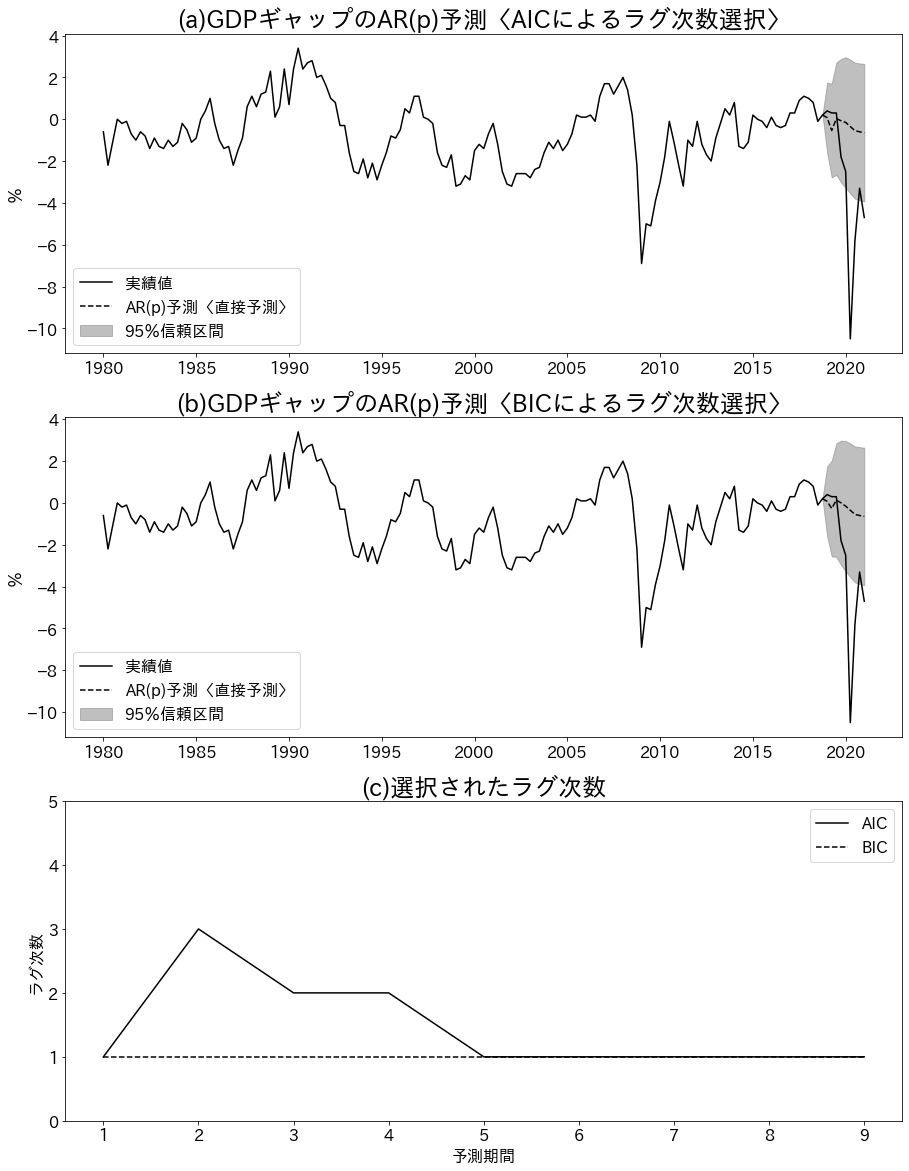

In [14]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a)GDPギャップのAR(p)予測〈AICによるラグ次数選択〉", fontsize=24)
ax1.plot(dti, caogap, label="実績値", color="black")
ax1.plot(
    dti[ssize - 1 : ssize + MAX_H],
    ar_forecast1[ssize - 1 : ssize + MAX_H, :],
    label="AR(p)予測〈直接予測〉",
    color="black",
    linestyle="dashed",
)
ax1.fill_between(
    np.ravel(dti[ssize - 1 : ssize + MAX_H]),
    np.ravel(ar_ubound1[ssize - 1 : ssize + MAX_H, :]),
    np.ravel(ar_lbound1[ssize - 1 : ssize + MAX_H, :]),
    color="grey",
    alpha=0.5,
    label="95％信頼区間",
)
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)GDPギャップのAR(p)予測〈BICによるラグ次数選択〉", fontsize=24)
ax2.plot(dti, caogap, label="実績値", color="black")
ax2.plot(
    dti[ssize - 1 : ssize + MAX_H],
    ar_forecast2[ssize - 1 : ssize + MAX_H, :],
    label="AR(p)予測〈直接予測〉",
    color="black",
    linestyle="dashed",
)
ax2.fill_between(
    np.ravel(dti[ssize - 1 : ssize + MAX_H]),
    np.ravel(ar_ubound2[ssize - 1 : ssize + MAX_H, :]),
    np.ravel(ar_lbound2[ssize - 1 : ssize + MAX_H, :]),
    color="grey",
    alpha=0.5,
    label="95％信頼区間",
)
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("％", fontsize=16)
ax3.set_title("(c)選択されたラグ次数", fontsize=24)
ax3.plot(
    pd.DataFrame(x for x in range(1, MAX_H + 1)).to_numpy(),
    pd.DataFrame(best_aic_lag).to_numpy(),
    label="AIC",
    color="black")
ax3.plot(
    pd.DataFrame(x for x in range(1, MAX_H + 1)).to_numpy(),
    pd.DataFrame(best_bic_lag).to_numpy(),
    label="BIC",
    color="black",
    linestyle="dashed",
)
ax3.legend(loc="upper right", fontsize=16)
ax3.tick_params(labelsize=16)
ax3.set_xlabel("予測期間", fontsize=16)
ax3.set_ylabel("ラグ次数", fontsize=16)
ax3.set_ylim(0, MAX_L + 1)